In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import collections
import lqg1d
import json

import numba

# Function definitions

In [3]:
def load_dataframe(folder):
    experiments = []
    for experiment in glob.glob(os.path.join(folder, '*_params.json')):
        with open(experiment, 'r') as f:
            params = json.load(f)

        experiments.append({k.upper():i for k,i in params.items()})
    experiments_df = pd.DataFrame(experiments)
    experiments_df = experiments_df.fillna('-')
    
    return experiments_df

In [4]:
def load_from_dataframe(df):
    return [pd.read_pickle(f + '.gzip') for f in df['FILENAME'].values]
        

In [5]:
def filter_experiments(**kwargs):
    df_filtered = kwargs['df']
    for k,v in kwargs.items():
        if v is not None:
            try:
                if isinstance(v, list):
                    df_filtered = df_filtered[df_filtered[k.upper()].isin(v)]
                else:
                    df_filtered = df_filtered[df_filtered[k.upper()] == v]
            except:
                pass
    return df_filtered

In [6]:
def my_plot(**kwargs):
    data_params = filter_experiments(**kwargs)
    
    free_vars = []
    for k,v in kwargs.items():
        if v is None or (k.upper() in data_params.columns and isinstance(v, list)):
            free_vars.append(k)

    free_vars = [s.upper() for s in free_vars]
    
    if len(free_vars) <= 0:
        data_params = data_params.sort_values(by=list(data_params.columns), ascending=False)
    else:
        data_params = data_params.sort_values(by=free_vars, ascending=False)

    data = load_from_dataframe(data_params)

    plt.rcParams["figure.figsize"] = (15,13)
    
    def plot_lines(**kwargs):
        MAX_T = kwargs['max_t'] if 'max_t' in kwargs else -1
        MIN_T = kwargs['min_t'] if 'min_t' in kwargs else 0
        STEP = kwargs['step'] if 'step' in kwargs else 1
        ALPHA = kwargs['alpha'] if 'alpha' in kwargs else 1

        if isinstance(kwargs['value'], list):
            params = kwargs
            ll = len(kwargs['value'])
            i = 1
            for v in kwargs['value']:
                plt.subplot((ll + 1)//2, 2, i)
                i+=1
                params['value'] = v
                plot_lines(**params)
        else:
            for d in data:
                d['J+J_DET'] = d['J'] + d['J_DET']
                d['J_JOURNEY+J_DET'] = d['J_JOURNEY'] + d['J_DET']
                try:
                    x = d['T'].values[MIN_T:MAX_T:STEP] // STEP
                    y = d[kwargs['value']].values[MIN_T:MAX_T:STEP]
                except:
                    x = d['T'].values[MIN_T:MAX_T:STEP] // STEP
                    y = np.zeros(x.shape[0])
                plt.plot(x, y, alpha=ALPHA)
                plt.xlabel('Timesteps')
                plt.ylabel(kwargs['value'])
                plt.title(kwargs['value'])
                
                if kwargs['value'] == 'J+J_DET':
                    plt.plot(x, [d['J+J_DET'][0]]*len(x), 'r-', label='_nolegend_')
                    print('Initial J+J_DET is: ', d['J+J_DET'][0])
                    print('Average J+J_DET is: ', np.average(d['J+J_DET']))
                if kwargs['value'] == 'J_JOURNEY+J_DET':
                    plt.plot(x, [d['J_JOURNEY+J_DET'][0]]*len(x), 'r-', label='_nolegend_')
                if kwargs['value'] == 'BUDGET':
                    plt.plot(x, [0]*len(x), 'r-', label='_nolegend_')
                    print('Budget is negative for: ', sum(d['BUDGET']<0), '/', d['BUDGET'].shape[0], ' times')
                if kwargs['value'] == 'J_JOURNEY':
                    plt.plot(x, [d['J_JOURNEY'][0]]*len(x), 'r-', label='_nolegend_')
                if kwargs['value'] == 'GRAD_DELTAW':
                    plt.plot(x, [0]*len(x), 'r-', label='_nolegend_')

    plot_lines(**kwargs)
    
    # Build legend

    legend = [' '.join(map(lambda x : ': '.join((x[0], x[1] if x[1] is not np.nan else '-')), zip(data_params.loc[:,free_vars].columns.values, s))) for s in data_params.loc[:,free_vars].values]

    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        

In [7]:
def get_random_seed(x):
    tokens = x.split('_')
    return int(tokens[-1])

In [8]:
def add_learning_rate(x):
    tokens = x.split('_')
    if (tokens[0] == 'Adam') or (tokens[0] == 'MonotonicNaiveGradient'):
        return tokens[1]
    else:
        return '-'

In [9]:
def get_avg_col(column):
    def get_average(x):
        return pd.DataFrame([x[column] for x in load_from_dataframe(x)]).mean().values
    return get_average

In [10]:
def get_std_col(column):
    def get_std(x):
        if column == 'J+J_DET':
            means_j = [x['J'] for x in load_from_dataframe(x)]
            means_jdet = [x['J_DET'] for x in load_from_dataframe(x)]
            return pd.DataFrame(a+b for a,b in zip(means_j, means_jdet)).std().values
        else:
            return pd.DataFrame([x[column] for x in load_from_dataframe(x)]).std().values
    return get_std

In [11]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [155]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{units}')
FIGURE_SIZE = (14,7)
ADJUST_LEFT=0.17
FONT_SIZE=28
LEGEND_SIZE=24

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [156]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b', lw=14),
                Line2D([0], [0], color='m', lw=14),
                Line2D([0], [0], color='orangered', lw=14)]

# Load experiments

In [179]:
BASE_FOLDER = 'EXPERIMENTS_FINAL_LONG/'

experiments_df2 = filter_experiments(df=load_dataframe(BASE_FOLDER), experiment=['ExpBudget_DetPolicy', 'ExpBudget_SemiDetPolicy', 'MonotonicOnlyTheta'])

In [180]:
experiments_df2['ALPHA'] = '-'
experiments_df2['RANDOM_SEED'] = experiments_df2['NAME'].apply(get_random_seed)

In [181]:
experiments_df2['SIGMA'] = '1.0'

In [182]:
BASE_FOLDER = 'GRID_LQG_CONFIDENCE/'

experiments_df = load_dataframe(BASE_FOLDER)

In [183]:
experiments_df['ALPHA'] = experiments_df['NAME'].apply(add_learning_rate)

In [184]:
experiments_df['RANDOM_SEED'] = experiments_df['NAME'].apply(get_random_seed)

In [185]:
newdf = filter_experiments(df=experiments_df2, sigma='1.0')

In [186]:
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))

In [187]:
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))

# NIPS Plots

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

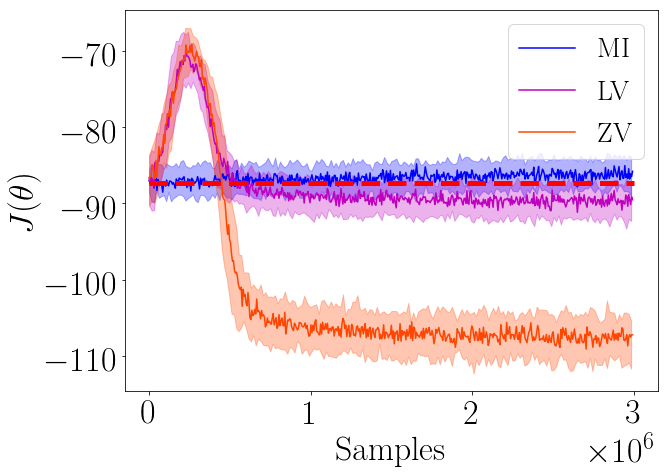

In [22]:
plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.16)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel('$J(\\theta)$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['MI', 'LV', 'ZV'], loc=1,  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.savefig('asdf.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

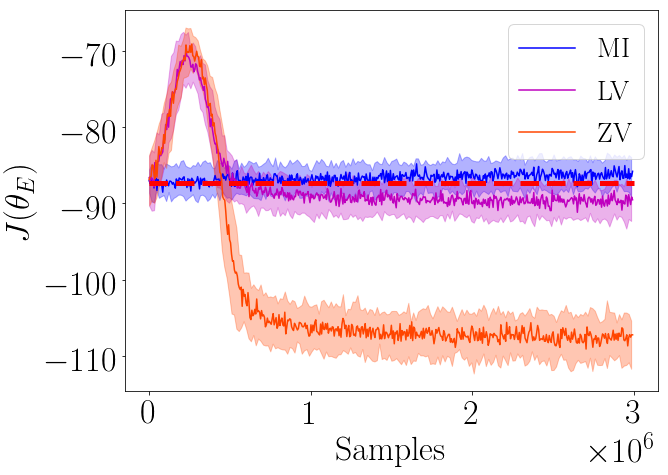

In [23]:
plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.16)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel('$J(\\theta_{E})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['MI', 'LV', 'ZV'], loc=1,  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.savefig('plot1.pdf')

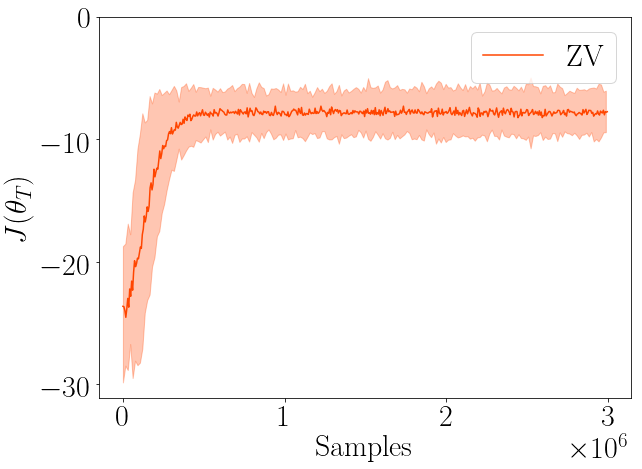

In [22]:
plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.16)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J_DET'))

colors = ['orangered']

K=3

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=30)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-K*stds)[::step_var], (means_stds+K*stds)[::step_var], alpha=0.3, color=c)
    
plt.ylabel(r'$J(\theta_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['ZV'])
plt.xticks([0, 1e06, 2e06, 3e06])
plt.yticks([-30, -20, -10, 0])
plt.savefig('plot2.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

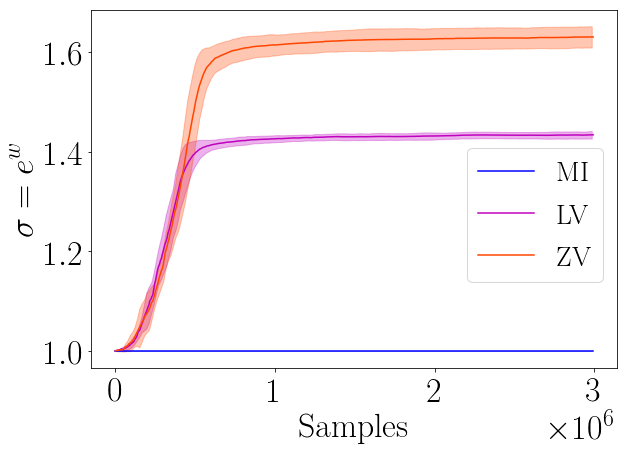

In [58]:
plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.17, bottom=0.17)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('SIGMA'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('SIGMA'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
    
plt.ylabel('$\\sigma=e^w$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['MI', 'LV', 'ZV'], loc=4, bbox_to_anchor=(1, 0.2),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])
plt.yticks([1.0, 1.2, 1.4, 1.6])
plt.savefig('plot3.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

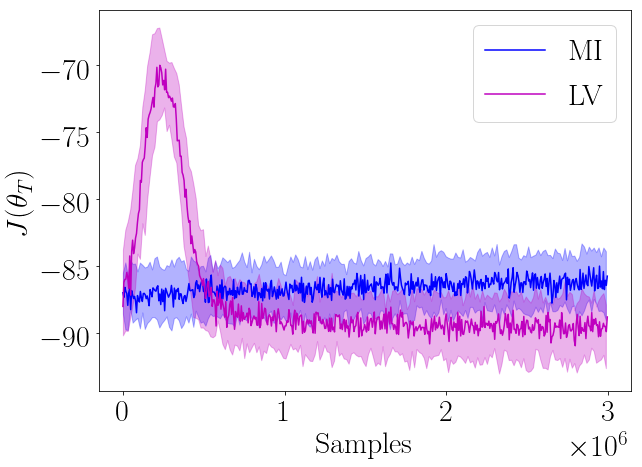

In [59]:
means_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))['MonotonicOnlyTheta']
stds_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))['MonotonicOnlyTheta']

plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.16)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J_DET'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=30)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    if name == 'MonotonicOnlyTheta':
        means = moving_average(means_monotonic, ma_mean)
        means_stds = moving_average(means_monotonic, ma_var)
        stds = moving_average(stds_monotonic, ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)

    
plt.ylabel(r'$J(\theta_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([0, 1e06, 2e06, 3e06])
plt.legend(['MI', 'LV'])

plt.savefig('plot4.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

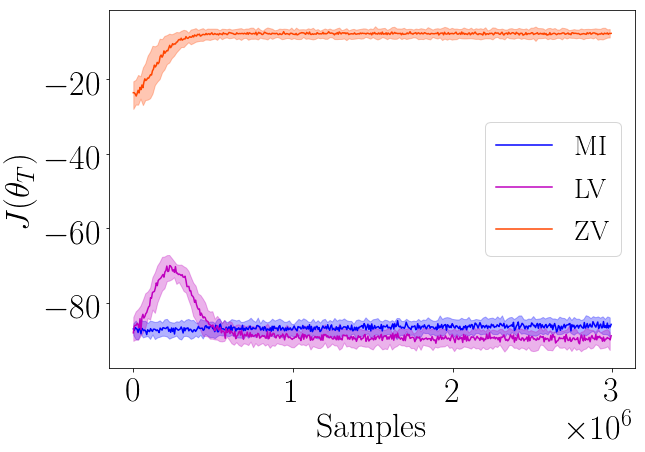

In [60]:
means_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))['MonotonicOnlyTheta']
stds_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))['MonotonicOnlyTheta']

plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.17, bottom=0.17)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J_DET'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    if name == 'MonotonicOnlyTheta':
        means = moving_average(means_monotonic, ma_mean)
        means_stds = moving_average(means_monotonic, ma_var)
        stds = moving_average(stds_monotonic, ma_var)
    elif name == 'ExpBudget_DetPolicy':
        stds*=2
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)

    
plt.ylabel(r'$J(\theta_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([0, 1e06, 2e06, 3e06])
plt.legend(['MI', 'LV', 'ZV'], prop={'size' : 28})

plt.savefig('plot5.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

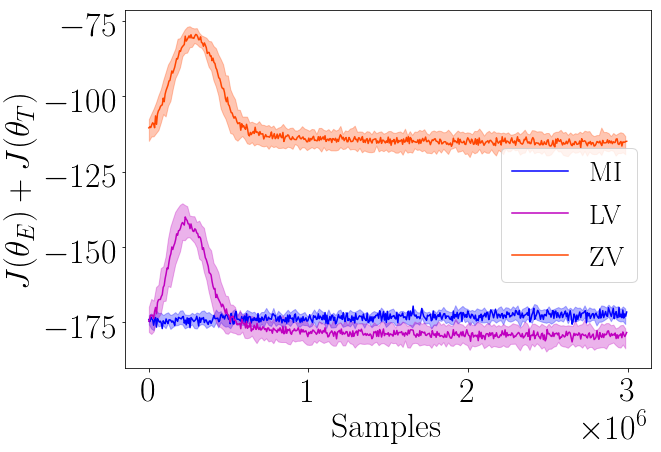

In [61]:
means_monotonic = 2*newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J'))['MonotonicOnlyTheta']
stds_monotonic = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J'))['MonotonicOnlyTheta']


plt.figure(figsize=(10,7))
plt.gcf().subplots_adjust(left=0.17, bottom=0.17)
average_J = newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J')) + newdf.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_J = newdf.groupby(['EXPERIMENT']).apply(get_std_col('J+J_DET'))

colors = ['b', 'm', 'orangered']

step_mean = 20
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    if name == 'MonotonicOnlyTheta':
        means = moving_average(means_monotonic, ma_mean)
        means_stds = moving_average(means_monotonic, ma_var)
        stds = moving_average(stds_monotonic, ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)

    
plt.ylabel('$J(\\theta_{E}) + J(\\theta_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([0, 1e06, 2e06, 3e06])
plt.legend(['MI', 'LV', 'ZV'],loc=4, bbox_to_anchor=(1, 0.2), prop={'size':28})

plt.savefig('plot6.pdf')

# Other plots

In [23]:
df = load_dataframe('EXPERIMENTS_FINAL_LONG/')

In [24]:
df['EXPERIMENT'].unique()

array(['ExpBudget_DetPolicy',
       'SimultaneousThetaAndSigma_two_thirds_theta', 'MonotonicOnlyTheta',
       'MonotonicZeroBudgetEveryStep', 'SimultaneousThetaAndSigma_half',
       'ExpBudget_NoDetPolicy', 'MonotonicThetaAndSigma',
       'ExpBudget_SemiDetPolicy', 'NoWorseThanBaselineEveryStep',
       'SimultaneousThetaAndSigma_two_thirds_sigma'], dtype=object)

In [25]:
df['RANDOM_SEED'] = df['NAME'].apply(get_random_seed)

In [26]:
df_small = df[df['RANDOM_SEED'] == 2]

In [27]:
average_J = df.groupby(['EXPERIMENT']).apply(get_avg_col('J'))

In [28]:
std_J = df.groupby(['EXPERIMENT']).apply(get_std_col('J'))

In [29]:
average_sigma = df.groupby(['EXPERIMENT']).apply(get_avg_col('SIGMA'))

In [30]:
std_sigma = df.groupby(['EXPERIMENT']).apply(get_std_col('SIGMA'))

In [31]:
average_theta = df.groupby(['EXPERIMENT']).apply(get_avg_col('THETA'))

In [32]:
std_theta = df.groupby(['EXPERIMENT']).apply(get_std_col('THETA'))

In [33]:
average_jjdet = df.groupby(['EXPERIMENT']).apply(get_avg_col('J')) + df.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))

In [34]:
std_jjdet = df.groupby(['EXPERIMENT']).apply(get_std_col('J+J_DET'))

In [35]:
average_jdet = df.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_jdet = df.groupby(['EXPERIMENT']).apply(get_std_col('J_DET'))

In [36]:
average_budget = df.groupby(['EXPERIMENT']).apply(get_avg_col('BUDGET'))
std_budget = df.groupby(['EXPERIMENT']).apply(get_std_col('BUDGET'))

## AAAI

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

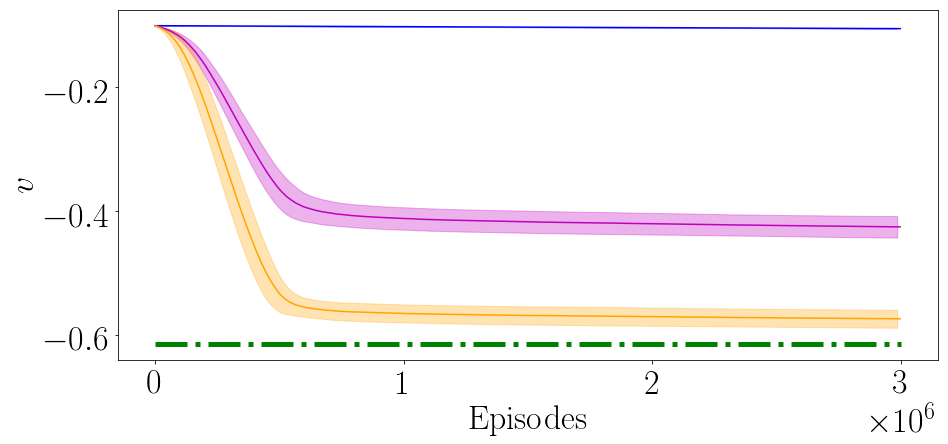

In [176]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['b', 'm', 'orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicThetaAndSigma', 'ExpBudget_NoDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_theta[name], ma_mean)
    means_stds = moving_average(average_theta[name], ma_var)
    stds = moving_average(std_theta[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
plt.plot([0,300*10000], np.ones(2) * -0.615, 'g-.', linewidth=5)
    
plt.ylabel('$v$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('theta.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

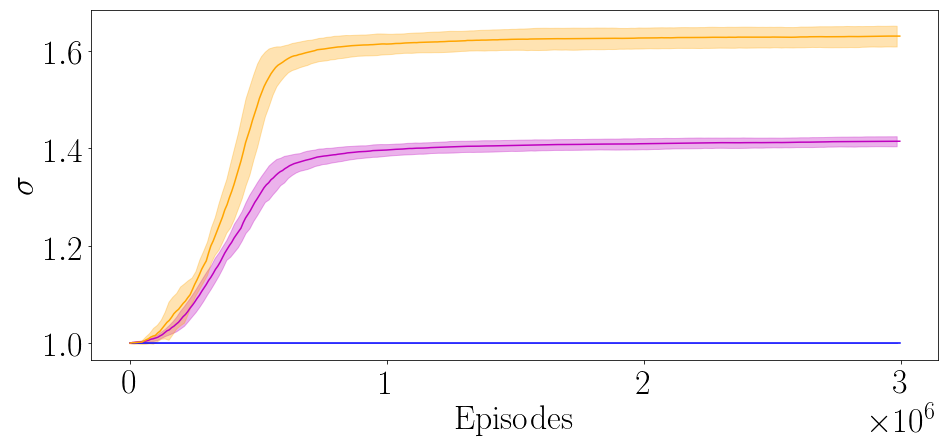

In [175]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['b', 'm', 'orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicThetaAndSigma', 'ExpBudget_NoDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_sigma[name], ma_mean)
    means_stds = moving_average(average_sigma[name], ma_var)
    stds = moving_average(std_sigma[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
#plt.plot([0,300*10000], np.ones(2) * -0.615, 'g-.', linewidth=5)
    
plt.ylabel('$\\sigma$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('sigma.pdf')

In [101]:
average_J['ExpBudget_NoDetPolicy']

array([-85.93608564, -89.82927293, -88.01161495, ..., -90.00333087,
       -88.03133935, -91.69039949])

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

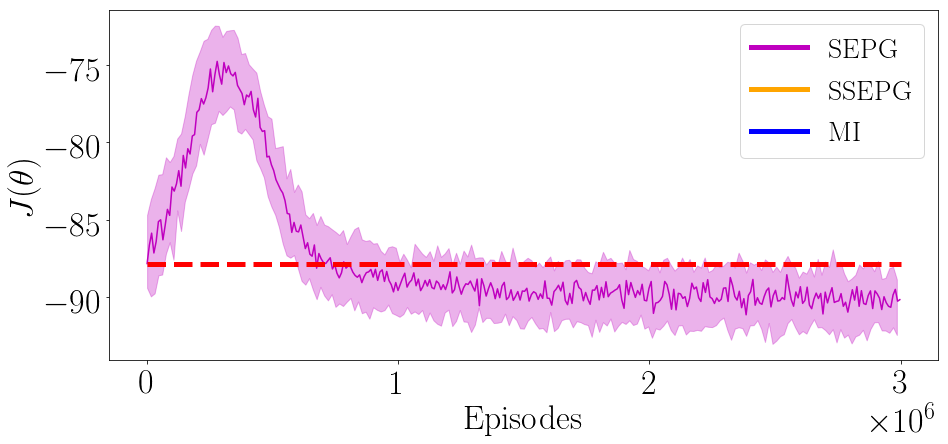

In [172]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['m']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_NoDetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    baseline = moving_average(average_J[name][0:ma_mean], ma_mean)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)

plt.plot([0],[-90],color='orange')
plt.plot([0],[-90],color='b')
plt.plot([0,300*10000], np.ones(2) * baseline, 'r--', linewidth=5)
#plt.plot([0,300*10000], np.ones(2) * -0.615, 'g-.', linewidth=5)
    
plt.ylabel('$J(\\theta)$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

leg = plt.legend(['SEPG', 'SSEPG','MI'], loc=1,  prop={'size': 28})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

plt.tight_layout()
plt.savefig('J.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

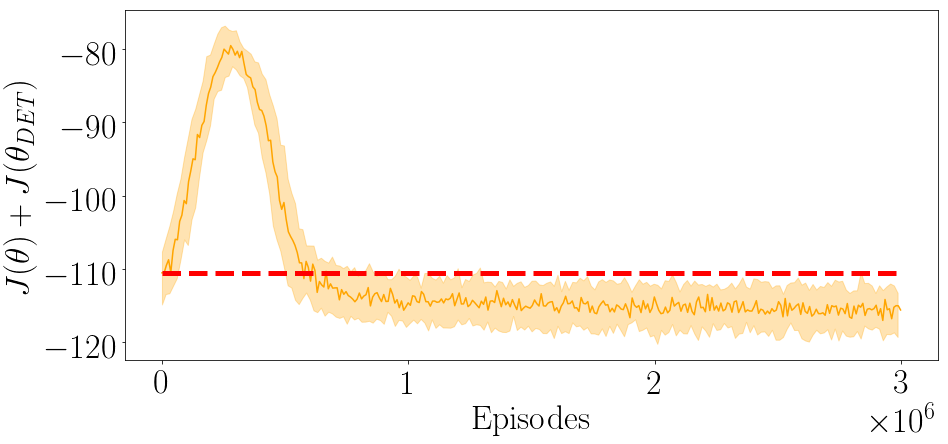

In [173]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_jjdet[name], ma_mean)
    means_stds = moving_average(average_jjdet[name], ma_var)
    stds = moving_average(std_jjdet[name], ma_var)
    
    baseline = moving_average(average_jjdet[name][0:ma_mean], ma_mean)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)


plt.plot([0,300*10000], np.ones(2) * baseline, 'r--', linewidth=5)
#plt.plot([0,300*10000], np.ones(2) * -0.615, 'g-.', linewidth=5)
    
plt.ylabel('$J(\\theta)+J(\\theta_{DET})$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('jjdet.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

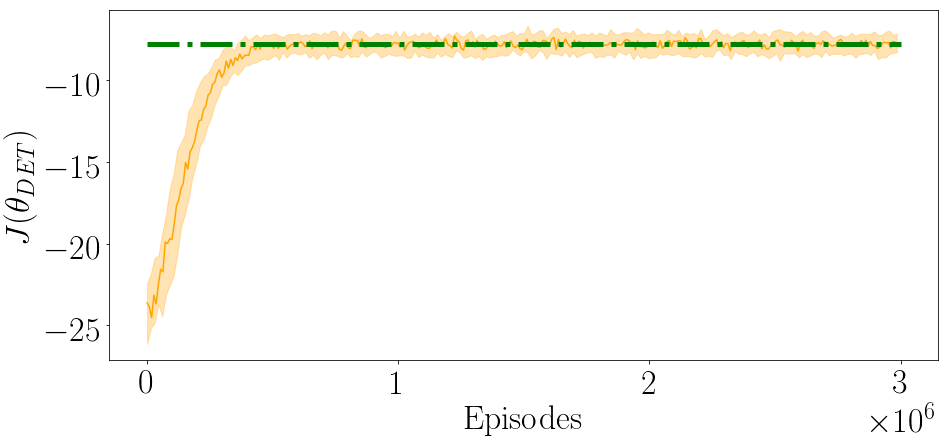

In [174]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_jdet[name], ma_mean)
    means_stds = moving_average(average_jdet[name], ma_var)
    stds = moving_average(std_jdet[name], ma_var)
    
    baseline = moving_average(average_jdet[name][0:ma_mean], ma_mean)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * baseline, 'r--', linewidth=5)
plt.plot([0,300*10000], np.ones(2) * -7.753, 'g-.', linewidth=5)
    
plt.ylabel('$J(\\theta_{DET})$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('jdet.pdf')

In [144]:
from matplotlib import patches
labels = ['a', 'b']
colors = ['b', 'm']
fig = plt.figure(figsize=(2, 1.25))
patches = [
    patches.Patch(color=color, label=label)
    for label, color in zip(labels, colors)]
fig.legend(patches, labels, loc='center', frameon=False)
plt.show()

<Figure size 144x90 with 0 Axes>

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

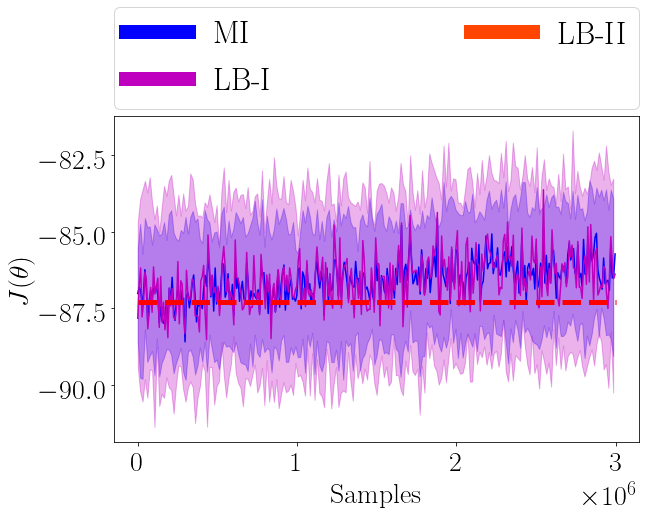

In [145]:
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['b', 'm', 'orangered']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'MonotonicThetaAndSigma']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$J(\theta)$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
lgd = plt.legend(custom_lines, ['MI', 'LB-I', 'LB-II'],  prop={'size': 1.3*LEGEND_SIZE}, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xticks([0, 1e06, 2e06, 3e06])

plt.savefig('newplot1.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

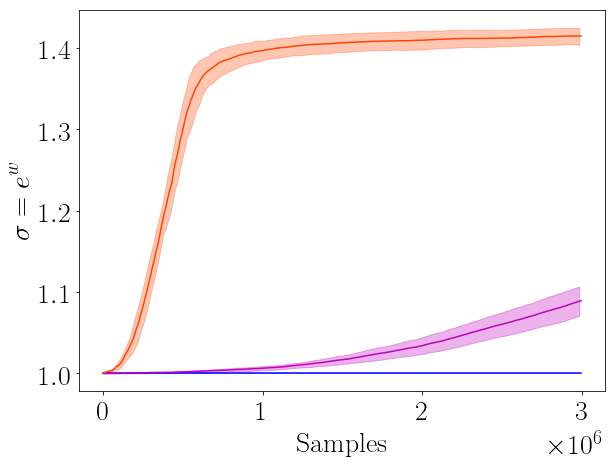

In [40]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['b', 'm', 'orangered']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'NoWorseThanBaselineEveryStep', 'ExpBudget_NoDetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_sigma[name], ma_mean)
    means_stds = moving_average(average_sigma[name], ma_var)
    stds = moving_average(std_sigma[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$\sigma = e^w$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'LB-I', 'LB-II'],  prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.savefig('newplot2.pdf', bbox_inches='tight')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

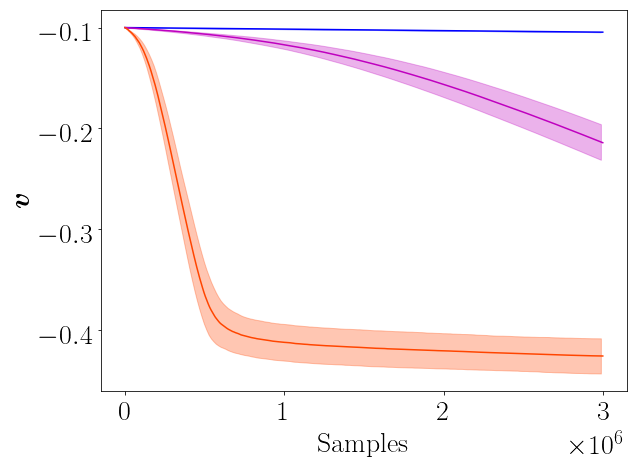

In [41]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['b', 'm', 'orangered']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'NoWorseThanBaselineEveryStep', 'ExpBudget_NoDetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_theta[name], ma_mean)
    means_stds = moving_average(average_theta[name], ma_var)
    stds = moving_average(std_theta[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$\boldsymbol{v}$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'LB-I', 'LB-II'],  prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.savefig('newplot3.pdf', bbox_inches='tight')

# First comparison

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

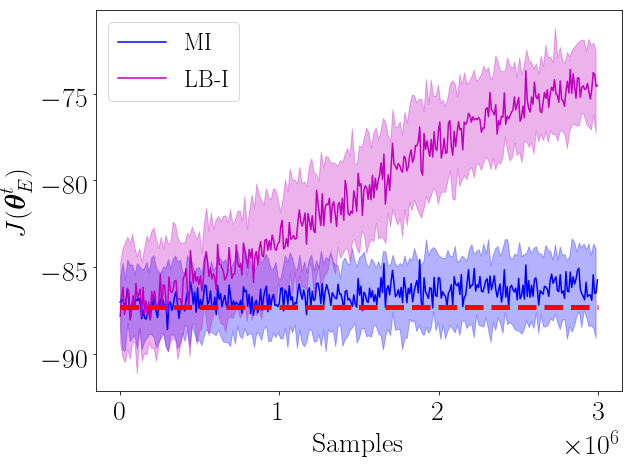

In [79]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['b', 'm', 'orangered']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'NoWorseThanBaselineEveryStep']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$J(\boldsymbol{\theta}^t_E)$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['MI', 'LB-I'],  prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.savefig('plot1.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

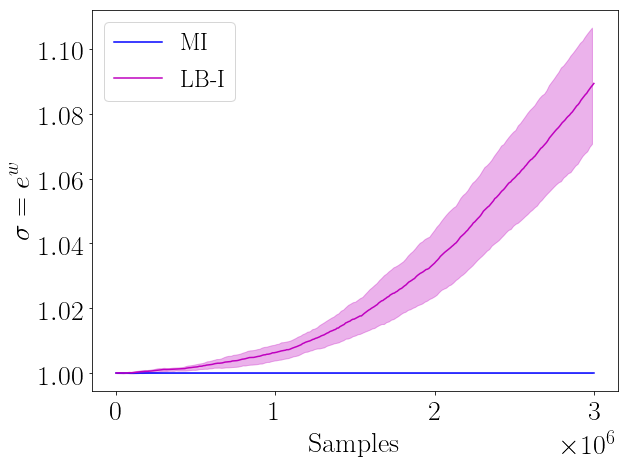

In [80]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_sigma
VAR_STD = std_sigma


colors = ['b', 'm', 'orangered']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'NoWorseThanBaselineEveryStep']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$\sigma=e^w$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['MI', 'LB-I'],  prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot2.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

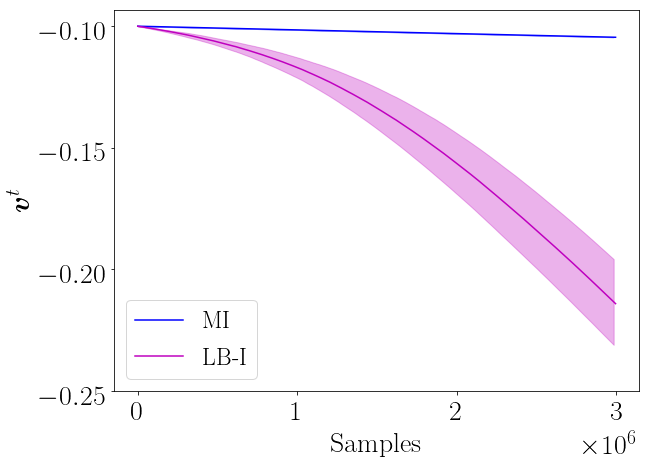

In [81]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_theta
VAR_STD = std_theta


colors = ['b', 'm', 'orangered']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicOnlyTheta', 'NoWorseThanBaselineEveryStep']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$\boldsymbol{v}^t$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['MI', 'LB-I'],  prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])
plt.yticks([-0.25, -0.20, -0.15, -0.10])

plt.savefig('plot3.pdf')

# Second comparison

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

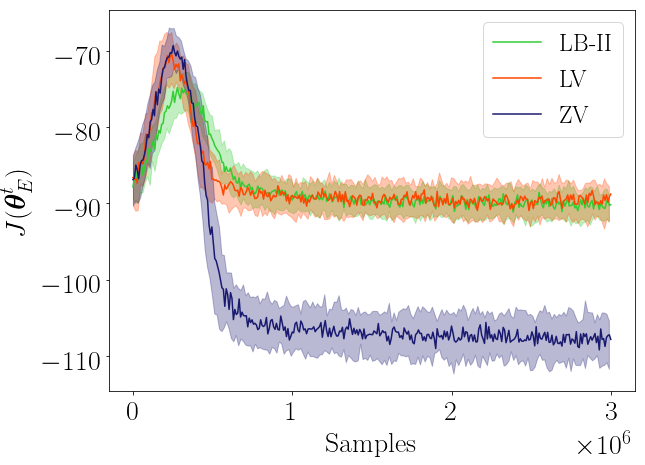

In [82]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_J
VAR_STD = std_J


colors = [ 'limegreen', 'orangered', 'midnightblue']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = [ 'ExpBudget_NoDetPolicy', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$J(\boldsymbol{\theta}^t_{E})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend([ 'LB-II', 'LV', 'ZV'],  prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot4.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

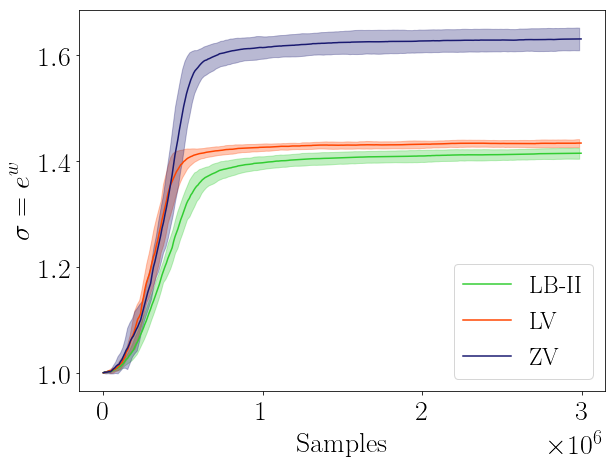

In [83]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_sigma
VAR_STD = std_sigma


colors = [ 'limegreen', 'orangered', 'midnightblue']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = [ 'ExpBudget_NoDetPolicy', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$\sigma=e^w$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend([ 'LB-II', 'LV', 'ZV'], prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot5.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

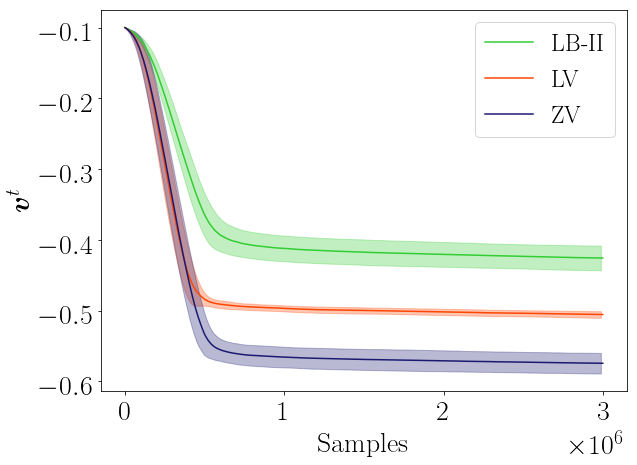

In [84]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_theta
VAR_STD = std_theta


colors = ['limegreen', 'orangered', 'midnightblue']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_NoDetPolicy', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$\boldsymbol{v}^t$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['LB-II', 'LV', 'ZV'],  prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot6.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

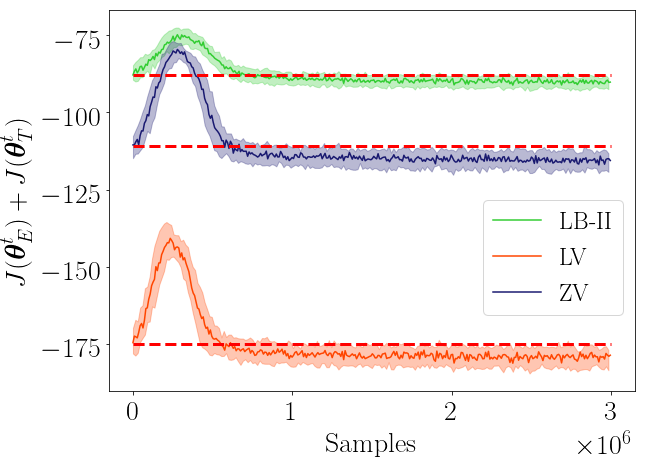

In [85]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_jjdet
VAR_STD = std_jjdet


colors = ['limegreen', 'orangered', 'midnightblue']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_NoDetPolicy', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
plt.plot([0,300*10000], np.ones(2) * -87.9, 'r--', linewidth=3)
plt.plot([0,300*10000], np.ones(2) * -111, 'r--', linewidth=3)
plt.plot([0,300*10000], np.ones(2) * -175, 'r--', linewidth=3)
    
plt.ylabel(r'$J(\boldsymbol{\theta}^t_{E})+J(\boldsymbol{\theta}^t_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['LB-II', 'LV', 'ZV'], loc=5, bbox_to_anchor=(1,0.35), prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot7.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

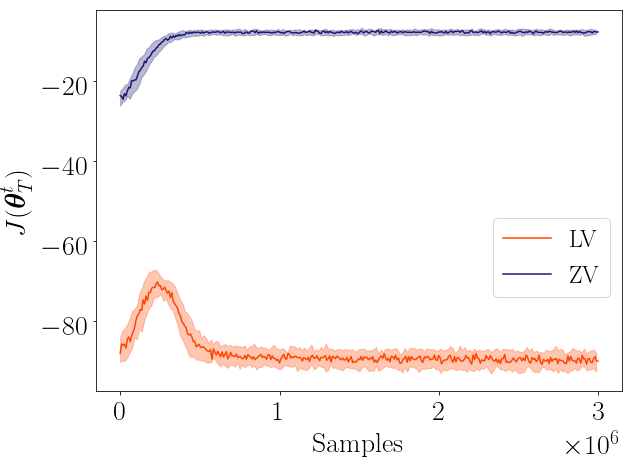

In [86]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_jdet
VAR_STD = std_jdet


colors = ['orangered', 'midnightblue']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$J(\boldsymbol{\theta}^t_{T})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['LV', 'ZV'], loc=5, bbox_to_anchor=(1,0.35), prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot8.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

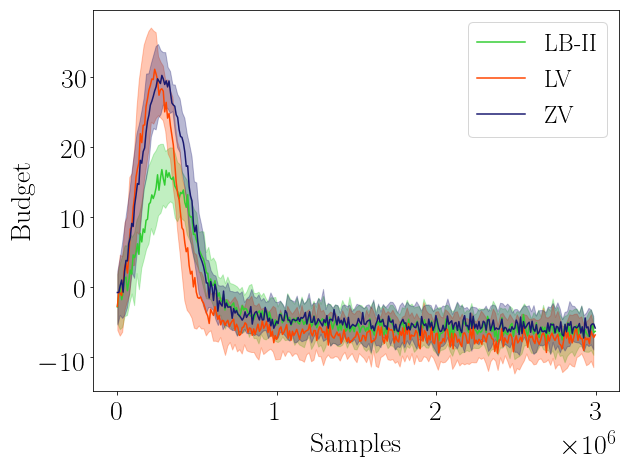

In [87]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_budget/100
VAR_STD = std_budget/100


colors = ['limegreen', 'orangered', 'midnightblue']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_NoDetPolicy', 'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.9, 'r--', linewidth=3)
#plt.plot([0,300*10000], np.ones(2) * -111, 'r--', linewidth=3)
#plt.plot([0,300*10000], np.ones(2) * -175, 'r--', linewidth=3)
    
plt.ylabel(r'Budget')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['LB-II', 'LV', 'ZV'], prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot13.pdf')

# THIRD COMPARISON

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

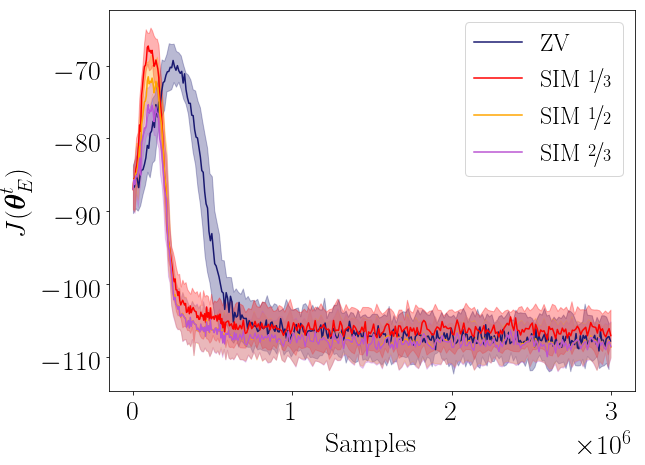

In [88]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_J
VAR_STD = std_J


colors = ['midnightblue', 'r', 'orange', 'mediumorchid']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy', 'SimultaneousThetaAndSigma_two_thirds_theta', 'SimultaneousThetaAndSigma_half', 'SimultaneousThetaAndSigma_two_thirds_sigma']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c,mult in zip(algos, colors, [300,200,200,200]):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    if mult==200:
        xx = 200*np.arange(len(means))[::step_mean]
        lenxx = len(xx)
        ss = 200*np.arange(len(means_stds))[::step_var]
        lenstd = len(ss)
        xfinalmean = np.hstack([xx[:lenxx//3], np.linspace(xx[lenxx//3 +1], 300*len(means), lenxx-(lenxx//3))])
        xfinalstd = np.hstack([ss[:lenstd//3], np.linspace(ss[lenstd//3 + 1], 300*len(means_stds), lenstd-(lenstd//3))])
    else:
        xfinalmean = 300*np.arange(len(means))[::step_mean]
        xfinalstd = 300*np.arange(len(means_stds))[::step_var]
    
    plt.plot(xfinalmean, means[::step_mean], color=c)
    plt.fill_between(xfinalstd,(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$J(\boldsymbol{\theta}^t_{E})$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['ZV', r'SIM $\nicefrac{1}{3}$', r'SIM $\nicefrac{1}{2}$', r'SIM $\nicefrac{2}{3}$'], prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot9.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

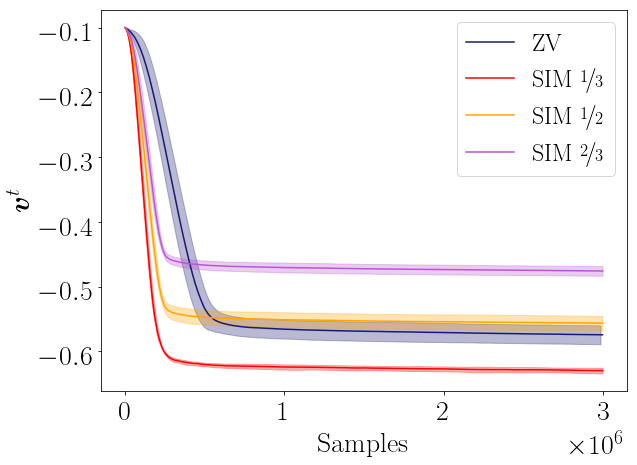

In [89]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_theta
VAR_STD = std_theta


colors = ['midnightblue', 'r', 'orange', 'mediumorchid']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy', 'SimultaneousThetaAndSigma_two_thirds_theta', 'SimultaneousThetaAndSigma_half', 'SimultaneousThetaAndSigma_two_thirds_sigma']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c,mult in zip(algos, colors, [300,200,200,200]):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    if mult==200:
        xx = 200*np.arange(len(means))[::step_mean]
        lenxx = len(xx)
        ss = 200*np.arange(len(means_stds))[::step_var]
        lenstd = len(ss)
        xfinalmean = np.hstack([xx[:lenxx//3], np.linspace(xx[lenxx//3 +1], 300*len(means), lenxx-(lenxx//3))])
        xfinalstd = np.hstack([ss[:lenstd//3], np.linspace(ss[lenstd//3 + 1], 300*len(means_stds), lenstd-(lenstd//3))])
    else:
        xfinalmean = 300*np.arange(len(means))[::step_mean]
        xfinalstd = 300*np.arange(len(means_stds))[::step_var]
    
    plt.plot(xfinalmean, means[::step_mean], color=c)
    plt.fill_between(xfinalstd,(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$\boldsymbol{v}^t$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['ZV', r'SIM $\nicefrac{1}{3}$', r'SIM $\nicefrac{1}{2}$', r'SIM $\nicefrac{2}{3}$'], prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot10.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

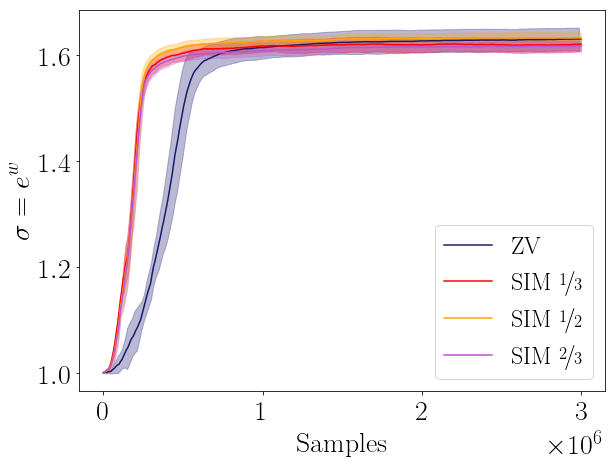

In [90]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_sigma
VAR_STD = std_sigma


colors = ['midnightblue', 'r', 'orange', 'mediumorchid']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy', 'SimultaneousThetaAndSigma_two_thirds_theta', 'SimultaneousThetaAndSigma_half', 'SimultaneousThetaAndSigma_two_thirds_sigma']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c,mult in zip(algos, colors, [300,200,200,200]):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    if mult==200:
        xx = 200*np.arange(len(means))[::step_mean]
        lenxx = len(xx)
        ss = 200*np.arange(len(means_stds))[::step_var]
        lenstd = len(ss)
        xfinalmean = np.hstack([xx[:lenxx//3], np.linspace(xx[lenxx//3 +1], 300*len(means), lenxx-(lenxx//3))])
        xfinalstd = np.hstack([ss[:lenstd//3], np.linspace(ss[lenstd//3 + 1], 300*len(means_stds), lenstd-(lenstd//3))])
    else:
        xfinalmean = 300*np.arange(len(means))[::step_mean]
        xfinalstd = 300*np.arange(len(means_stds))[::step_var]
    
    plt.plot(xfinalmean, means[::step_mean], color=c)
    plt.fill_between(xfinalstd,(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
    
plt.ylabel(r'$\sigma=e^w$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['ZV', r'SIM $\nicefrac{1}{3}$', r'SIM $\nicefrac{1}{2}$', r'SIM $\nicefrac{2}{3}$'], prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot11.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

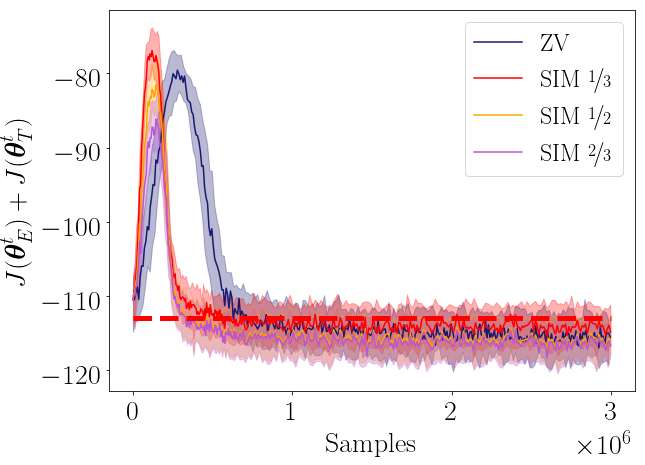

In [91]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

VAR_MEAN = average_jjdet
VAR_STD = std_jjdet


colors = ['midnightblue', 'r', 'orange', 'mediumorchid']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy', 'SimultaneousThetaAndSigma_two_thirds_theta', 'SimultaneousThetaAndSigma_half', 'SimultaneousThetaAndSigma_two_thirds_sigma']
plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c,mult in zip(algos, colors,[300,200,200,200]):
    means = moving_average(VAR_MEAN[name], ma_mean)
    means_stds = moving_average(VAR_MEAN[name], ma_var)
    stds = moving_average(VAR_STD[name], ma_var)
    
    if mult==200:
        xx = 200*np.arange(len(means))[::step_mean]
        lenxx = len(xx)
        ss = 200*np.arange(len(means_stds))[::step_var]
        lenstd = len(ss)
        xfinalmean = np.hstack([xx[:lenxx//3], np.linspace(xx[lenxx//3 +1], 300*len(means), lenxx-(lenxx//3))])
        xfinalstd = np.hstack([ss[:lenstd//3], np.linspace(ss[lenstd//3 + 1], 300*len(means_stds), lenstd-(lenstd//3))])
    else:
        xfinalmean = 300*np.arange(len(means))[::step_mean]
        xfinalstd = 300*np.arange(len(means_stds))[::step_var]
        
    plt.plot(xfinalmean, means[::step_mean], color=c)
    plt.fill_between(xfinalstd,(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
plt.plot([0,300*10000], np.ones(2) * -113, 'r--', linewidth=5)
    
plt.ylabel(r'$J(\boldsymbol{\theta}^t_E) + J(\boldsymbol{\theta}^t_T)$')
plt.xlabel('Samples')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(['ZV', r'SIM $\nicefrac{1}{3}$', r'SIM $\nicefrac{1}{2}$', r'SIM $\nicefrac{2}{3}$'], prop={'size': LEGEND_SIZE})
plt.xticks([0, 1e06, 2e06, 3e06])


plt.savefig('plot12.pdf')

# MOUNTAIN CAR

In [190]:
df = load_dataframe('MC_INITBUDGET')

In [213]:
df

,APPROXIMATE_GRADIENTS,DELTA,EXPERIMENT,FILENAME,GAMMA,MAX_ITER,NAME,N_MAX,N_MIN,N_TOT,PARALLEL,SIGMA,THETA_0,THETA_1,USE_LOCAL_STATS,VERBOSE
0,True,0.9,ExpBudget_DetPolicy,MC_INITBUDGET/Det_0.2_1iK2ZWeqhFWCEPyY,0.99,15000,Det_0.2_1,500000,100,30000000,True,0.6,0.0,0.0,True,True
1,True,0.9,ExpBudget_DetPolicy,MC_INITBUDGET/Det_0.2_1_NODISCOUNTiK2ZWeqhFWCEPyY,0.99,15000,Det_0.2_1_NODISCOUNT,500000,100,30000000,True,0.2,0.0,0.0,True,True
2,True,0.9,Adam,MC_INITBUDGET/Adam_0.1_1iK2ZWeqhFWCEPyY,0.99,15000,Adam_0.1_1,500000,100,30000000,True,0.2,0.0,0.0,True,True
3,True,0.9,Adam,MC_INITBUDGET/Adam_0.0001_1iK2ZWeqhFWCEPyY,0.99,15000,Adam_0.0001_1,500000,100,30000000,True,0.2,0.0,0.0,True,True
4,True,0.9,ExpBudget_DetPolicy,MC_INITBUDGET/Det_0.2_budget10iK2ZWeqhFWCEPyY,0.99,15000,Det_0.2_budget10,500000,100,30000000,True,0.2,0.0,0.0,True,True
5,True,0.9,MonotonicNaiveGradient,MC_INITBUDGET/Naive_0.0001_1iK2ZWeqhFWCEPyY,0.99,15000,Naive_0.0001_1,500000,100,30000000,True,0.2,0.0,0.0,True,True
6,True,0.9,Adam,MC_INITBUDGET/Adam_0.1iK2ZWeqhFWCEPyY,0.99,15000,Adam_0.1,500000,100,30000000,True,0.2,0.0,0.0,True,True


/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

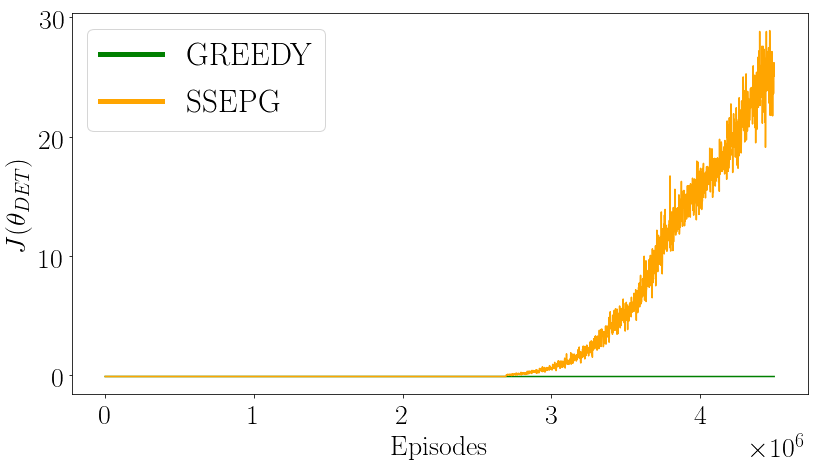

In [216]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)


colors = ['green', 'orange']
df = load_dataframe('MC_INITBUDGET/')
varname = 'J_DET'

step_mean = 5


#mcgood = filter_experiments(df=load_from_dataframe(df=df), name='Det_0.2_budget10')[0]
#mcbad = filter_experiments(df=load_from_dataframe(df=df), name='Adam_0.1_1')[0]
#df_array = [ mcgood]
df_array = load_from_dataframe(filter_experiments(df=df, name=['Det_0.2_budget10', 'Adam_0.1_1']))

plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for ddd,c in zip(df_array,colors):
    means = ddd[varname]
    
    xfinalmean = 300*ddd['T'][::step_mean]
        
    plt.plot(xfinalmean, means[::step_mean],color=c)
    
    
plt.ylabel(r'$J(\theta_{DET})$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
leg = plt.legend(['GREEDY','SSEPG'], prop={'size': 1.3*LEGEND_SIZE})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

plt.xticks([0, 1e06, 2e06, 3e06, 4e06])


plt.savefig('mc1.pdf',  bbox_inches='tight')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

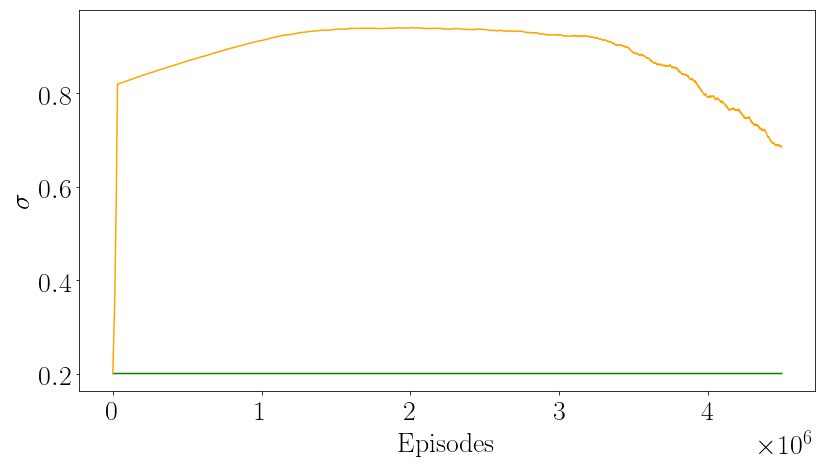

In [209]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)


colors = ['green', 'orange']
df = load_dataframe('MC_INITBUDGET/')
varname = 'SIGMA'

step_mean = 5


#mcgood = filter_experiments(df=load_from_dataframe(df=df), name='Det_0.2_budget10')[0]
#mcbad = filter_experiments(df=load_from_dataframe(df=df), name='Adam_0.1_1')[0]
#df_array = [ mcgood]
df_array = load_from_dataframe(filter_experiments(df=df, name=['Det_0.2_budget10', 'Adam_0.1_1']))

plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for ddd,c in zip(df_array,colors):
    means = ddd[varname]
    
    xfinalmean = 300*ddd['T'][::step_mean]
        
    plt.plot(xfinalmean, means[::step_mean],color=c)
    
    
plt.ylabel(r'$\sigma$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#leg = plt.legend(['GREEDY','SSEPG'], prop={'size': 1.3*LEGEND_SIZE})
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(5.0)

plt.xticks([0, 1e06, 2e06, 3e06, 4e06])


plt.savefig('mc2.pdf',  bbox_inches='tight')

In [221]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)


colors = ['green', 'orange']
df = load_dataframe('MC_INITBUDGET/')
varname = 'MEAN'

step_mean = 5


#mcgood = filter_experiments(df=load_from_dataframe(df=df), name='Det_0.2_budget10')[0]
#mcbad = filter_experiments(df=load_from_dataframe(df=df), name='Adam_0.1_1')[0]
#df_array = [ mcgood]
df_array = load_from_dataframe(filter_experiments(df=df, name=['Det_0.2_budget10', 'Adam_0.1_1']))

plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
for ddd,c in zip(df_array,colors):
    means = ddd[varname]
    
    xfinalmean = 300*ddd['T'][::step_mean]
        
    plt.plot(xfinalmean, means[::step_mean],color=c)
    
    
plt.ylabel(r'$\sigma$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#leg = plt.legend(['GREEDY','SSEPG'], prop={'size': 1.3*LEGEND_SIZE})
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(5.0)

plt.xticks([0, 1e06, 2e06, 3e06, 4e06])


plt.savefig('mc2.pdf',  bbox_inches='tight')

KeyError: 'MEAN'

<Figure size 1008x504 with 0 Axes>